# Extracting information from dataset


This notebook presents a case study to retrieve information from MazurkaBL dataset, provide tools to visualise it and imports models for dataset analysis.

## Import libraries

In [1]:
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as bd
import IPython.display as ipd
from scipy.io import wavfile
from IPython.display import Image
from data_processing import prepare_dataset, get_names_from_mazurka, plot_beat_dyn, plot_dyn_with_markings_values_boxplots, plot_dyn_change_curves, prepare_dataset_change_points, get_clusters_and_print_outlier_cluster_names, plot_sones_with_cp, plot_total_cps

## Retrieve MazurkaBL dataset

The MazurkaBL dataset was created from 2000 selected recordings from the CHARM Mazurka dataset. It contains score-aligned loudness, beat, and expressive marking data for analysing expressive variations of Chopin Mazurkas. It covers a total of 44 different Chopin Mazurkas with an average of 45 different professional interpretations.

The files that are loaded below include for each recording: time in seconds for each score beat, dynamic value for each score beat, expressive markings and their locations in score beat, and markings related to change in dynamics and their locations in score beat.

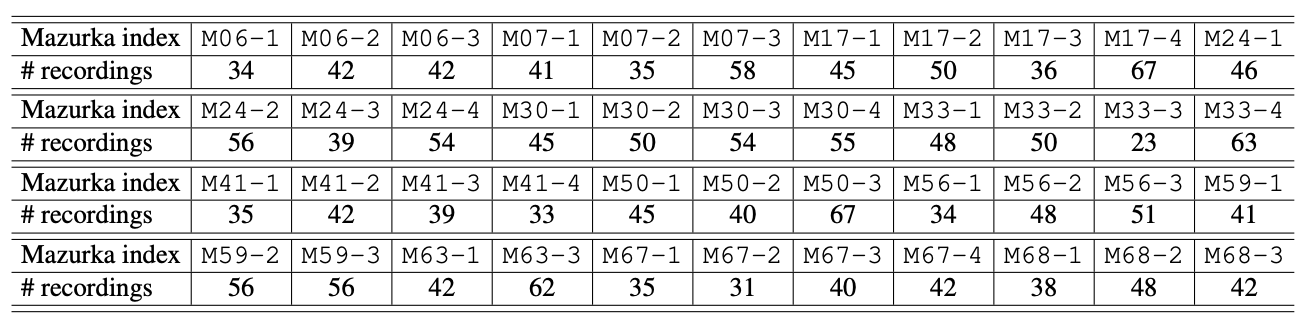

In [2]:
# Mazurka indeces:
Image("../media/mazurka_inds.png", width=768, height=18)

In [3]:
files_beat = glob.glob('../beat_time/*.csv')
files_dyn = glob.glob('../beat_dyn/*.csv')
files_mark = glob.glob('../markings/*.csv')
files_mark_dyn = glob.glob('../markings_dyn/*.csv')

Mazurka_info = prepare_dataset(files_beat, files_dyn, files_mark, files_mark_dyn)

Retrieving information from the .csv files...
Done!


In [4]:
# Print out stuff!

pianist_ID = Mazurka_info['M24-2'][3].id
pianist_timing = Mazurka_info['M24-2'][3].beat
pianist_dynamics = Mazurka_info['M24-2'][3].dyn  # smoothed sone values

print(len(pianist_dynamics))

360


### Plotting timing and dynamics variations 

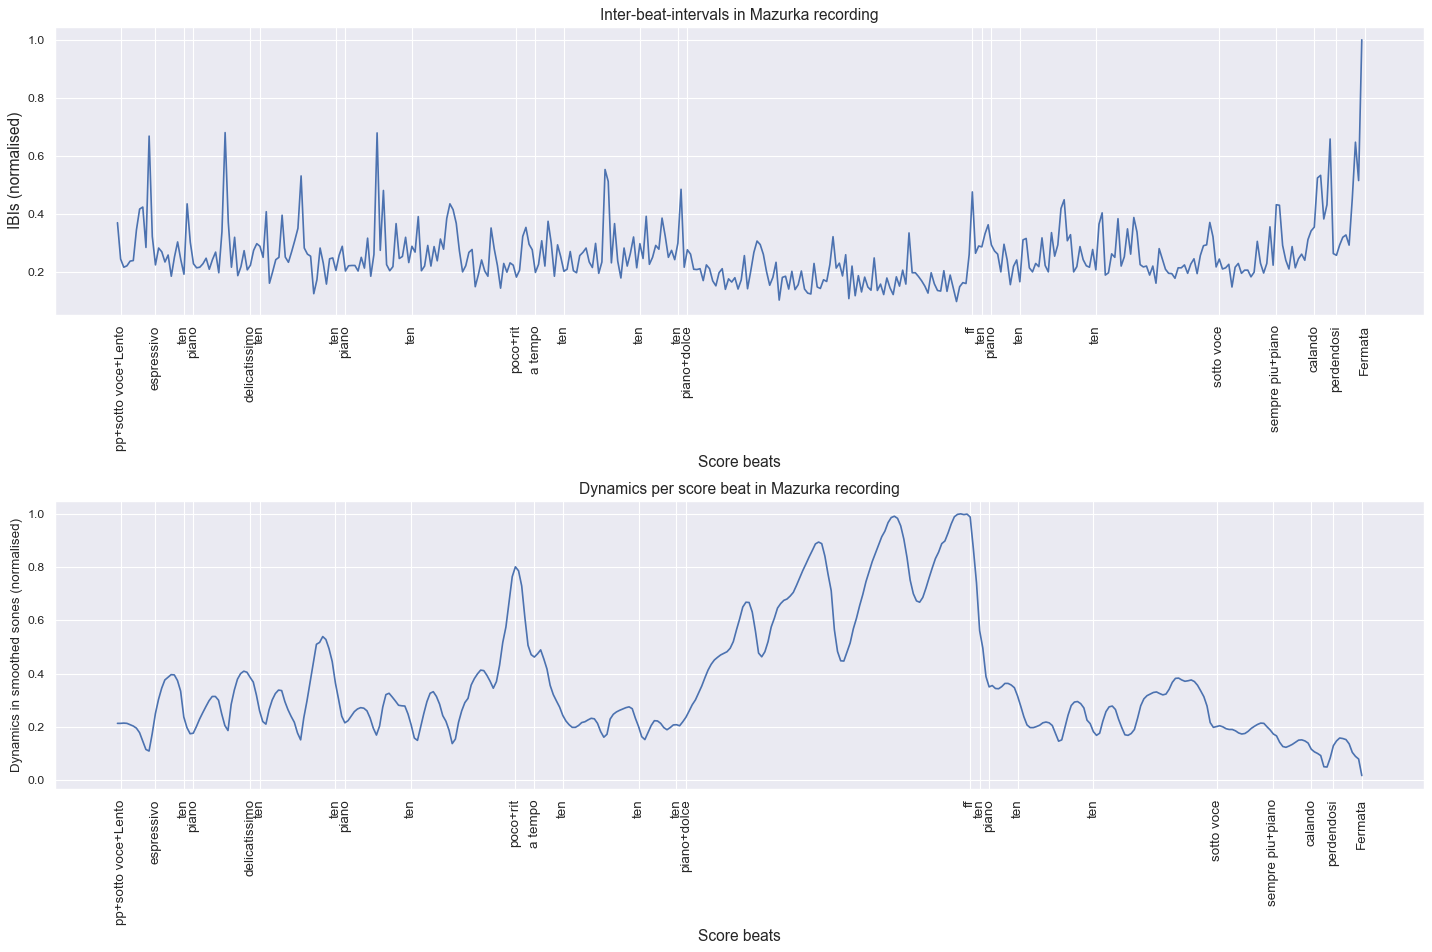

In [11]:
plot_beat_dyn(Mazurka_info['M17-4'][:1])
# plot_beat_dyn(Mazurka_info['M68-2'][:2])

### Comparing the dynamic values at the positions of dynamic markings

Pianists:  ['Csalog', 'Rosen', 'Horowitz', 'Moravec', 'Paderewski', 'Anderszewski', 'Chiu', 'Rubinstein(1939)', 'Indjic', 'Smith', 'Luisada', 'Kissin', '', 'Rubinstein(1966)', 'Brailowsky', 'Uninsky', 'Biret', 'Fliere', 'Block', 'Cortot', 'Falvay', 'Cohen', 'Francois', 'Shebanova', 'Magaloff', 'Rubinstein(1952)', 'Uninsky', 'Czerny-Stefanska', 'Lushtak', 'Perlemuter', 'Kapell', 'Poblocka', 'Rangell', 'Ferenczy', 'Milkina', 'Osinska', 'Blumental', 'Blet', 'Mohovich', 'Wasowski', 'Gornostaeva', 'Kushner', 'Neighaus', 'Gierzod', 'Bunin', 'Boshniakovich', 'Schilhawsky', 'Afanassiev', 'Magin', 'Ezaki', 'Ohlsson', 'Badura-Skoda', 'Bacha', 'Sztompka', 'Richter', 'Barbosa', 'Zak', 'Farrell', 'Paperno', 'Malcuzynski', 'Tomsic', 'Czerny-Stefanska']


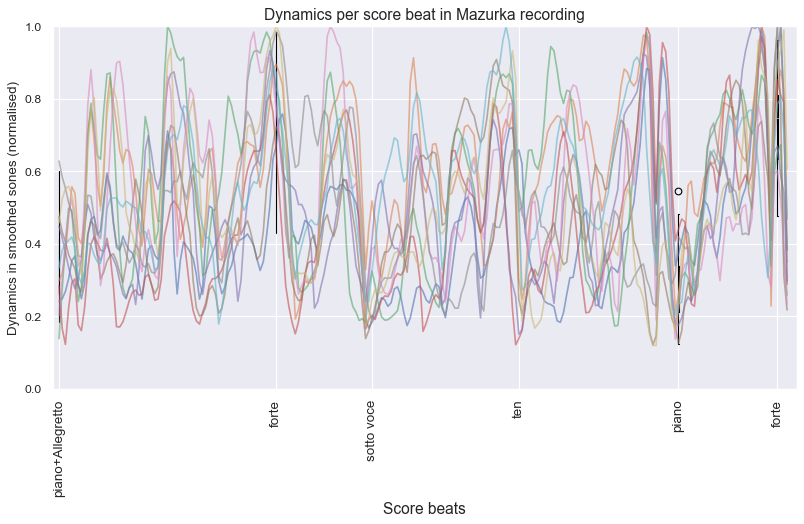

In [14]:
print('Pianists: ', get_names_from_mazurka(Mazurka_info['M63-3']))
plot_dyn_with_markings_values_boxplots(Mazurka_info['M63-3'], list(range(10)))
# plot_dyn_with_markings_values_boxplots(Mazurka_info['M63-3'], ['Magaloff', 'Rubinstein(1966)'])

Example: compare two interpretations of the same score excerpt, one played by Rubinstein and one played by Magallof:

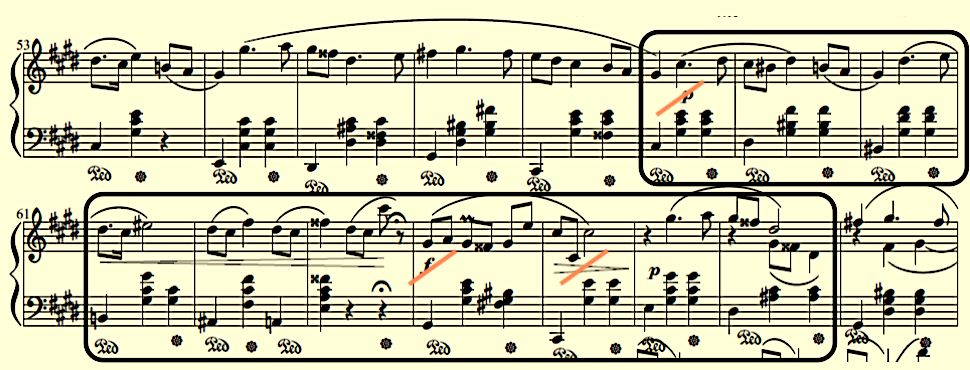

In [15]:
# Score:
Image("../media/M63_3_exceprt.png", width=768, height=18)

In [16]:
fs1, data1 = wavfile.read('../media/dynamics_demo1_rubinstein-2896.wav')
ipd.Audio(data1, rate=fs1)


In [17]:
fs2, data2 = wavfile.read('../media/dynamics_demo2_magallof-2914.wav')
ipd.Audio(data2, rate=fs2)

## Discrete transitions for dynamic markings

By the time we have the dynamic value that corresponds to each marking, we create our data in a pairwise manner by
subtracting from dynamic value $l_b$ the value of the previous marking, $l_{b−1}$ for every marking position $b$ in each Mazurka. The result is discretised as follows:

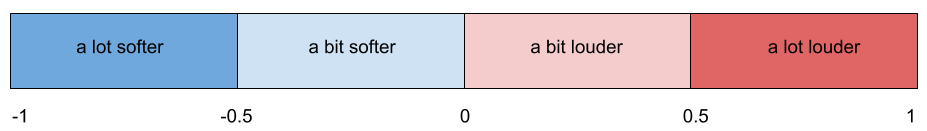

In [18]:
# Transition levels:
Image("../media/levels.png", width=588, height=12)


The methodology relies on the linearity of the sone values so that we are able to create levels of a same linear distance. This discretization steps allows us to handle the noisy loudness data.

In [19]:
# Plot showing the discrete transition between dynamic markings. 
# Example: if the transision is from 'p' to 'f', the x-tick will be "('p', 'f')".
plot_dyn_change_curves(Mazurka_info['M17-4'][0:1])

Following up, we can create clusters of the curves obtained above so as to further analyse the resulting shapes and distinguish "unusual" behaviour. 
Method: k-means 

Pianists in outlier (smallest) cluster:  ['Zimerman', 'Fiorentino', 'Cortot', 'Perlemuter', 'Kiepura', 'Korecka-Soszkowska', 'Vardi']


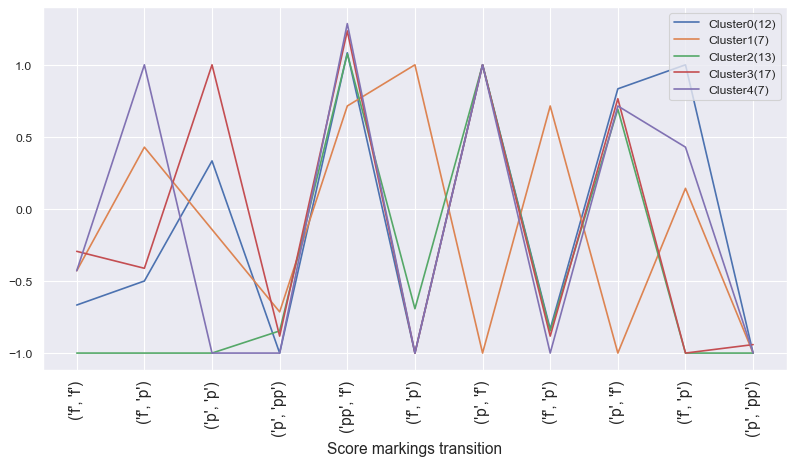

In [20]:
get_clusters_and_print_outlier_cluster_names(Mazurka_info['M24-2'], 5)

## Change points in dynamics

In order to further investigate our raw data of the sone values, we apply Killick, Fearnhead, and Eckley’s Pruned Exact Linear Time (PELT) method. This is a change-point detection method used for time series. We further introduce a penalised contrast by setting penalty values for the cost function used in order to predict the points (more details in [1]).

folder_sones = ('../sones/')
files_cp_per_recording_in_mazurka = glob.glob('../change_points_data/cp_per_maz_rec_PELT/*.txt')
files_total_cp = glob.glob('../change_points_data/cp_per_beat_tables_PELT/*.csv')

Mazurka_info_cp = prepare_dataset_change_points(folder_sones, files_cp_per_recording_in_mazurka, files_total_cp, files_mark)


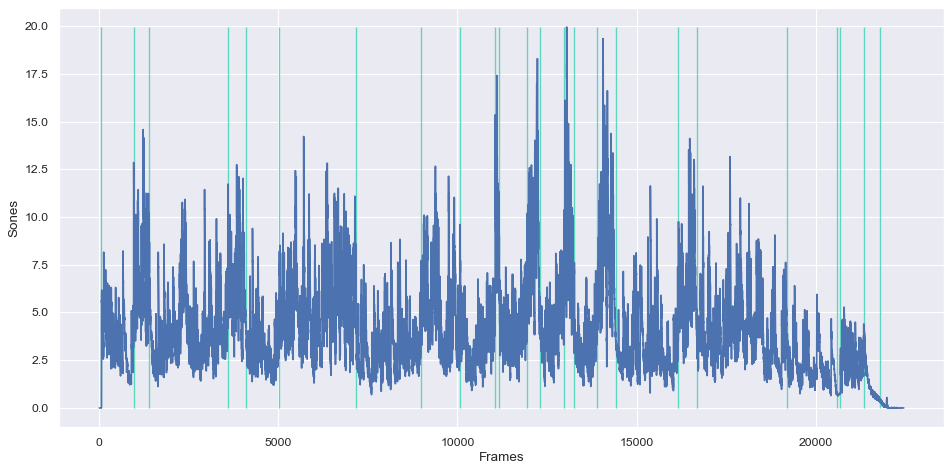

In [24]:
plot_sones_with_cp(Mazurka_info_cp['M17-4'], Mazurka_info['M17-4'], [2])

The following plot shows the beat locations of the change points across recordings as bar charts for each Mazurka.

In [25]:
plot_total_cps(Mazurka_info_cp, 'M06-3')
# plot_total_cps(Mazurka_info_cp, 'M63-3')

The results show that significant dynamic score markings do indeed
correspond to change points and evidence suggests that change points in score
positions without dynamic markings serve structural salient events or events
based on temporal changes:

In [28]:
Image("../media/cp_peak_meaning_pie.png", width=488, height=10) 

## Extra take-away messages

Results from study using MazurkaBL dataset in Machine learning for bi-directional mapping between dynamic markings in the score and performed loudness: [Kosta et al. 2016]

> Loudness values and markings can be predicted relatively well when trained on different recordings of the same piece, but fail dismally when trained on the pianist's recordings of other pieces.

> Score features may trump individual style when modelling loudness choices.


There are similar results from study using MazurkaBL dataset in Machine learning for tempo-loudness interactions at specific tempo and loudness score markings: [Vaquero et al. 2017] 

[1] Kosta, K., O. F. Bandtlow, E. Chew (2017). Dynamic change points in music audio capture dynamic markings in score. 18th International Society for Music Information Retrieval Conference (ISMIR), Late-Breaking and Demo Session, Suzhou, China]